# Поиск оптимальной стратегии методом SARSA

Реализуем TD метод SARSA для поиска оптимальной стратегии с помощью ОИС с итерацией по 𝜀-мягким стратегиям с GLIE, то есть с постепенным убыванием 𝜀. Код для "табличного" агента, обучающегося Q-функции, у нас уже написан. Модифицируем этот код, убрав возможность обновлять оценку Q-функции по методу выборочного среднего. Соответственно, тогда не нужен словарь для хранения числа посещений пар состояние-действие.

Класс в Python, реализующий "табличного" агента, содержал следующие базовые функции:

    reset() для сброса значений Q-функции
    update() для обновления значений Q(s,a) в сторону цели обновления goal
    get_action() для выбора действий по eps-жадной стратегии относительно текущей Q функции
    
Однако, потребуется ещё ряд функций. TD методам для формирования цели требуется запросить у агента значения Q-функции. Для "табличного" агента `agent` до значений Q-функции легко добраться командой `agent.Q[s][a]`. Однако, далее мы увидим, что TD методы (и методы МК) можно применять не только к табличным агентам. Чтобы сохранить модульную структуру кода, добавим в класс табличного агента метод `get_Q()`, который по входным аргументам `s,a` будет возвращать значение Q-функции $Q(s,a)$.

Кроме того, для симуляции взаимодействия с уже обученным агентом будет удобен метод `best_action()`, который будет выдавать жадное действие относительно текущей Q-функции.

In [5]:
import numpy as np
from collections import defaultdict
from tqdm import tqdm

class TableAgent:
    def __init__(self, env, eps = 0.1, alpha = 0.1):
        self.nA = env.action_space.n # число действий
        self.Q = defaultdict(lambda: np.zeros(self.nA))   # словарь для хранения оценок ценностей пар состояние-действие
        self.eps = eps               
        self.alpha = alpha           # параметр шага обучения
            
    def reset(self):
        self.Q = defaultdict(lambda: np.zeros(self.nA))
        
    # выбор eps-жадного действия        
    def get_action(self, state):
        if np.random.rand() < self.eps:
            return np.random.choice(self.nA)

        return self.best_action(state)
    
    # выбор жадного действия        
    def best_action(self, state):
        return np.argmax(self.Q[state])
    
    def update(self, state, act, goal):
        # обновление оценки с постоянным шагом обновления
        self.Q[state][act] += self.alpha*(goal - self.Q[state][act])
        
    def get_Q(self, state, act):
        return self.Q[state][act]
  
    def play(self, env, n_episodes):
        for _ in tqdm(range(n_episodes)):
            state, _ = env.reset()
            while True:
                # выбираем лучшие действия
                action = self.best_action(state)
                state, reward, terminated, truncated, _ = env.step(action)
                if terminated or truncated:
                    break

Далее, напишем управляющую функцию `SARSA_control()` для обучения агента по методу SARSA.

In [7]:
def SARSA_control(env, agent, n_episodes=10000, gamma = 1.0,
                  eps_start=1.0, eps_decay = 0.99, eps_min = 0.001):
    agent.eps = eps_start
    
    for _ in tqdm(range(n_episodes)):
        state, _ = env.reset()
        action = agent.get_action(state)
        # запускаем эпизод взаимодействия со средой
        while True:
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_action = agent.get_action(next_state)
            upd_goal = reward + gamma * agent.get_Q(next_state, next_action)
            agent.update(state, action, upd_goal)
            
            state, action = next_state, next_action      
            if terminated or truncated:
                break

        # уменьшение доли шагов исследования
        agent.eps = max(agent.eps * eps_decay, eps_min)           

### Пример 1

Рассмотрим ещё одну задачу о сеточном мире из библиотеки `gymnaisum`, которая называется `CliffWalking-v0`. Она полезна для наглядного сравнения некоторых особенностей работы трёх TD-методов: SARSA, Q-learning, Expected SARSA.

Сеточный мир представляет собой матрицу из клеток размера 4 на 12 клеток, индексация клеток такая же, что и у матрицы размера 4 на 12 в `Python`.
	
1. Клетка $(3,0)$ - это стартовое состояние
2. Клетка $(3,11)$ - это заключительное состояние.
3. Клетки $(3,1)$,...,$(3,10)$ представляют собой утёс.

4 действия: влево, вниз, вправо, вверх, перемещают агента по полю с клетками, выход за пределы поля означает, что агент остаётся на месте. 

Вознаграждения: 

    -1 за каждый временной шаг, 
    -100 на попадание на клетку с утёсом и возвращение в стартовую клетку. 
    
В заключительном состоянии эпизод завершается.

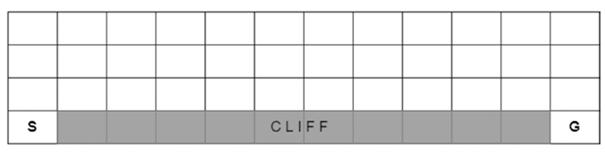

Рассмотрим решение этой задачи методом SARSA.

In [9]:
import gymnasium as gym
# Создание среды
env = gym.make('CliffWalking-v0')
n_episodes = 1000
env = gym.wrappers.RecordEpisodeStatistics(env, n_episodes)

# создание табличного агента
agent = TableAgent(env, alpha = 0.25, eps=0.01)

# обучение агента и получение доходов по эпизодам
SARSA_control(env, agent, n_episodes = n_episodes)

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 512.81it/s]


Выведем график доходов за эпизоды, полученных в взаимодействия агента со средой.

In [11]:
import matplotlib.pyplot as plt
# для того, чтобы избежать ошибок при построении графиков
#import os
#os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# в названии графика среднее вознаграждение за 20 последних эпизодов
def plot_rewards(env_name, returns, label):
    fig = plt.figure(figsize=(16, 4))
    plt.title("Среда: "+env_name+", Средний доход за последние 20 эпизодов = "+str(np.mean(returns[-20:])))
    plt.plot(returns, label=label)
    plt.grid()
    plt.legend()
    plt.ylim(-100, 0)
    plt.show()

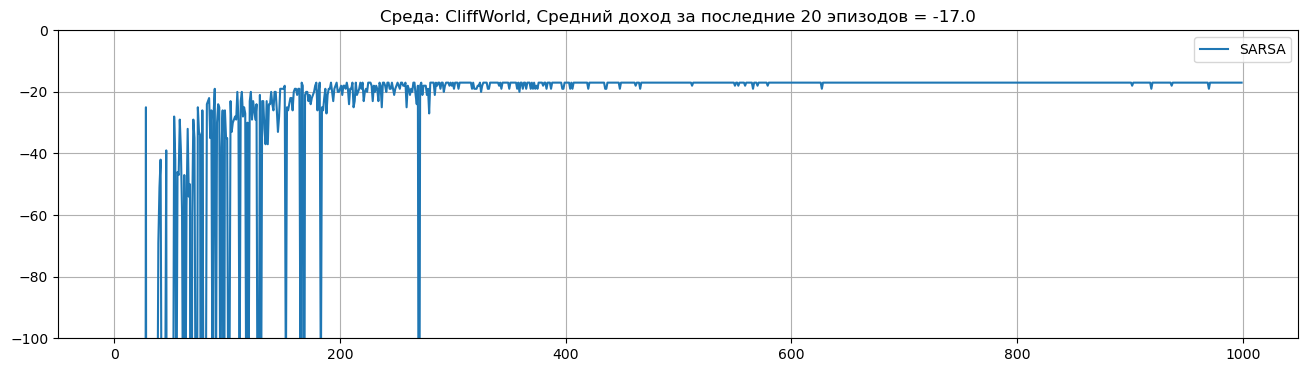

In [13]:
# график доходов
returns = np.array(env.return_queue)
plot_rewards("CliffWorld", returns, 'SARSA')

График доходов по эпизодам показывает, что уже к 500 эпизоду агент достиг фиксированной стратегии. Общий доход близок к оптимальному, хотя и не оптимален. Рассмотрим стратегию, которой обучился агент.

In [15]:
import time
from IPython.display import clear_output

env = gym.make("CliffWalking-v0", render_mode='ansi')

state, _ = env.reset()
print(env.render())

while True:
    state, reward, terminated, truncated, _ = env.step(agent.best_action(state)) 
    
    time.sleep(.4)
    clear_output(wait=True)
    print(env.render())

    if terminated or truncated:
        break
    
env.close()

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x




Можно вывести жадные действия агента относительно обученной Q-функции, используя метод `agent.best_action()`.

In [17]:
opt_actions = np.zeros(48)
for s in range(48):
    opt_actions[s] = agent.best_action(s)

opt_actions.reshape(4,12)    

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2.],
       [0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 2.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

Стратегия агента такова, что он обходит утёс как можно дальше. Ясно, что это не кратчайший путь для достижения цели и эта стратегия не оптимальна. В случае детеминированной стратегии, лучший вариант будет на 4 шага короче и путь будет проходить вдоль утёса.

Почему агент обучился именно такой "безопасной" стратегии? Это объясняется тем, что SARSA в ходе обучения совершает итерации по eps-жадным стратегиям и всегда есть малый шанс свалиться с утёса, если проходить вдоль него. Это показывает одну из проблем методов обучения с единой стратегией: исследовательские действия агента могут мешать нахождению оптимальной стратегии, когда агент уже достаточно много знает о среде, поскольку эти действия могут переместить агента в состояния с низкой ценностью.

Этого можно будет избежать при обучении по методу Q-learning, который является методом с разделённой стратегией. В рамках этого метода агент генерирует траектории по исследовательской поведенческой стратегии, а обучается целевой оптимальной детерминированной стратегии.

### Пример 2 

Применим метод SARSA для обучения табличного агента для решения задачи о такси `Taxi-v3`.

In [19]:
import gymnasium as gym
# Создание среды
env = gym.make("Taxi-v3")
n_episodes = 40000
env = gym.wrappers.RecordEpisodeStatistics(env, n_episodes)

# создание табличного агента
agent = TableAgent(env, alpha = 0.05, eps=0.1)

# обучение агента и получение доходов по эпизодам
SARSA_control(env, agent, n_episodes = n_episodes, eps_decay = 0.9999, eps_min = 0.001)

100%|███████████████████████████████████████████████████████████████████████████| 40000/40000 [00:41<00:00, 968.18it/s]


In [21]:
0.9999**40000

0.018311975883074864

Выведем график доходов за эпизоды, полученных в взаимодействия агента со средой.

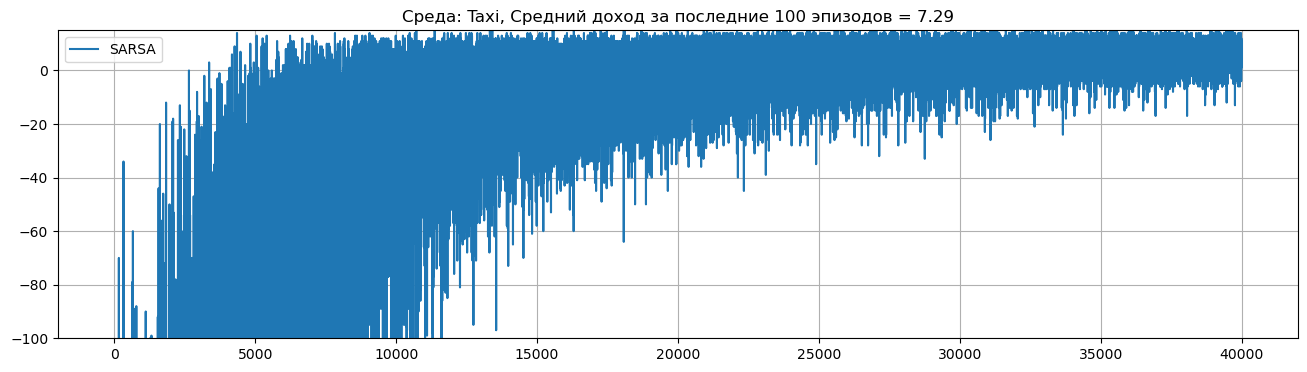

In [35]:
def plot_rewards(env_name, returns, label):
    fig = plt.figure(figsize=(16, 4))
    plt.title("Среда: "+env_name+", Средний доход за последние 100 эпизодов = "+str(np.mean(returns[-100:])))
    plt.plot(returns, label=label)
    plt.grid()
    plt.legend()
    plt.ylim(-100, 15)
    plt.show()

# график доходов
returns = np.array(env.return_queue)
plot_rewards("Taxi", returns, 'SARSA')

Сначала обучение идёт довольно медленно, поскольку агент действует по eps-стратегии с высоким eps. Но в ходе взаимодействия, с накоплением опыта, получением достаточно хороших оценок и снижением eps, агент действует по всё более хорошей стратегии, и число шагов на эпизод снижается.

Запустим симуляцию для обученного агента на 10 000 эпизодах и найдём среднее вознаграждение.

In [37]:
n_episodes = 10000
env = gym.make("Taxi-v3")
env = gym.wrappers.RecordEpisodeStatistics(env, n_episodes)

agent.play(env, n_episodes)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4124.52it/s]


Можно вывести гистограмму полученных вознаграждений.

Средний доход за эпизод равен: 7.9135
Минимальный доход за эпизод равен: 3.0
Максимальный доход за эпизод равен: 15.0


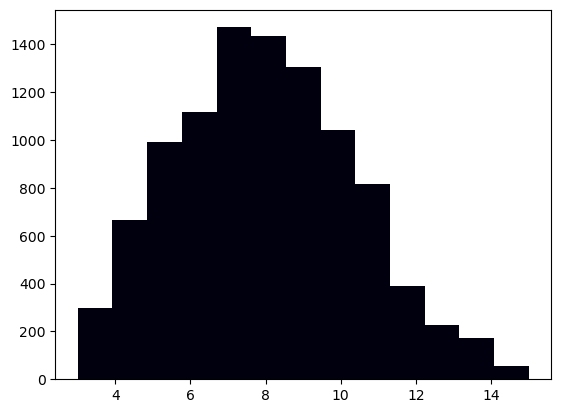

In [39]:
print('Средний доход за эпизод равен:', np.mean(env.return_queue))
print('Минимальный доход за эпизод равен:', np.min(env.return_queue))
print('Максимальный доход за эпизод равен:', np.max(env.return_queue))

import matplotlib.pyplot as plt
plt.hist(env.return_queue, bins=13, color='#00000f')
plt.show()

Из гистограммы ясно, что минимальное вознаграждение равно 3. Действительно, такое вознаграждение может быть при самом худшем варианте начального расположения. Например, такси в точке Y, пассажир в точке G, точка назначения в точке Y. Оптимальное движение займёт 17 временных шагов с посадкой пассажира и общий доход будет равен +3.

Косвенно это указывает на то, что найденная стратегия оптимальна.

In [43]:
import time
from IPython.display import clear_output

env = gym.make("Taxi-v3", render_mode='ansi')
state, _ = env.reset()
print(env.render())

while True:
    state, reward, terminated, truncated, _ = env.step(agent.best_action(state)) # выбрать действие случайно
    
    time.sleep(.2)
    clear_output(wait=True)      
    print(env.render())
    if terminated or truncated:
        break

env.close()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

